## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (plus script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (as shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarifiy and explain them.
* Make sure that **number cells consecutively starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells`.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Simple Data Analysis and Logistic Regression Classification 

## The Pima Indian diabetes

We want to predict whether a vector of text features corresponds to a patient having diabetes

### Attribute Information:

Patterns have 8 numeric features plus a 0-1 class label.

1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. Diastolic blood pressure (mm Hg) 
4. Triceps skin fold thickness (mm) 
5. 2-Hour serum insulin (mu U/ml) 
6. Body mass index (weight in kg/(height in m)^2) 
7. Diabetes pedigree function 
8. Age (years) 
9. Class variable (0 or 1) 


More details and actual data available in https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import time
import pickle
import gzip

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

np.set_printoptions(precision=3)

## Loading Data

The dataset can be obtained from many sources,although perhaps with different feature names. An example is

https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [4]:
f_name = '..\\pima.csv'
df_pima = pd.read_csv(f_name, sep=',')

print( "num_rows: %d\tnum_columns: %d\n" % (df_pima.shape[0], df_pima.shape[1]) )
print( "Column names:\n", list(df_pima.columns) )

vars_pima   = list(df_pima.columns[ : -1])
target_pima = df_pima.columns[-1]

num_rows: 768	num_columns: 9

Column names:
 ['numPregnant', 'glucose', 'bloodPress', 'skinThick', 'insulin', 'massIndex', 'pedigree', 'age', 'label']


## Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms

### Descriptive analysis

In [5]:
df_pima.describe(include='all').round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
numPregnant,768.0,3.85,3.37,0.00,1.00,3.00,6.00,17.00
glucose,768.0,120.89,31.97,0.00,99.00,117.00,140.25,199.00
bloodPress,768.0,69.11,19.36,0.00,62.00,72.00,80.00,122.00
skinThick,768.0,20.54,15.95,0.00,0.00,23.00,32.00,99.00
insulin,768.0,79.80,115.24,0.00,0.00,30.50,127.25,846.00
massIndex,768.0,31.99,7.88,0.00,27.30,32.00,36.60,67.10
pedigree,768.0,0.47,0.33,0.08,0.24,0.37,0.63,2.42
age,768.0,33.24,11.76,21.00,24.00,29.00,41.00,81.00
label,768.0,0.35,0.48,0.00,0.00,0.00,1.00,1.00


There are features with strange minimum vales, in fact, all but `numPregnant, pedigree` or `age`.

We have to decide what to do with them and the first step is to count these strange values.

In [6]:
for feature in ["glucose", "bloodPress", "skinThick", "insulin", "massIndex"]:
    print("valores 0 in %s:\t%d" % (feature, (df_pima[feature].values == 0.).sum()))

valores 0 in glucose:	5
valores 0 in bloodPress:	35
valores 0 in skinThick:	227
valores 0 in insulin:	374
valores 0 in massIndex:	11


We are going to drop the 0 values in `glucose, bloodPress` and `massIndex`.

In [7]:
idx_ok = df_pima['glucose'].values > 0.
idx_ok = np.logical_and(idx_ok, df_pima['bloodPress'].values > 0.)
idx_ok = np.logical_and(idx_ok, df_pima['massIndex'].values > 0.)

df_pima = df_pima.loc[ idx_ok ]

We re-describe the new DataFrame.

In [8]:
df_pima.describe().round(decimals=3).T

,count,mean,std,min,25%,50%,75%,max
numPregnant,724.0,3.866,3.363,0.000,1.000,3.000,6.000,17.00
glucose,724.0,121.883,30.750,44.000,99.750,117.000,142.000,199.00
bloodPress,724.0,72.401,12.380,24.000,64.000,72.000,80.000,122.00
skinThick,724.0,21.443,15.733,0.000,0.000,24.000,33.000,99.00
insulin,724.0,84.494,117.017,0.000,0.000,48.000,130.500,846.00
massIndex,724.0,32.467,6.889,18.200,27.500,32.400,36.600,67.10
pedigree,724.0,0.475,0.332,0.078,0.245,0.379,0.628,2.42
age,724.0,33.351,11.765,21.000,24.000,29.000,41.000,81.00
label,724.0,0.344,0.475,0.000,0.000,0.000,1.000,1.00


### Boxplots

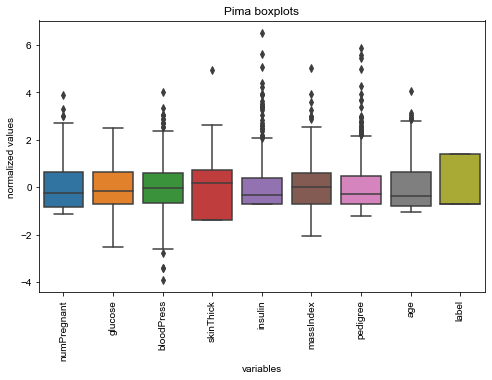

In [9]:
########## feature boxplots 

df_pima_normalizado = (df_pima - df_pima.mean()) / df_pima.std() #normalizar para tener rangos uniformes en histogramas

plt.figure( figsize=(8, 5))
plt.title("Pima boxplots")
sns.set_style("white")
bx_plot = sns.boxplot(data=df_pima_normalizado)
#bx_plot = sns.boxplot(data=df_housing)
plt.xticks(rotation=90)
plt.xlabel("variables")
plt.ylabel("normalized values")
plt.show()

### Histograms and scatterplots

Plot histograms of groups of all variables plus target.

E:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
E:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


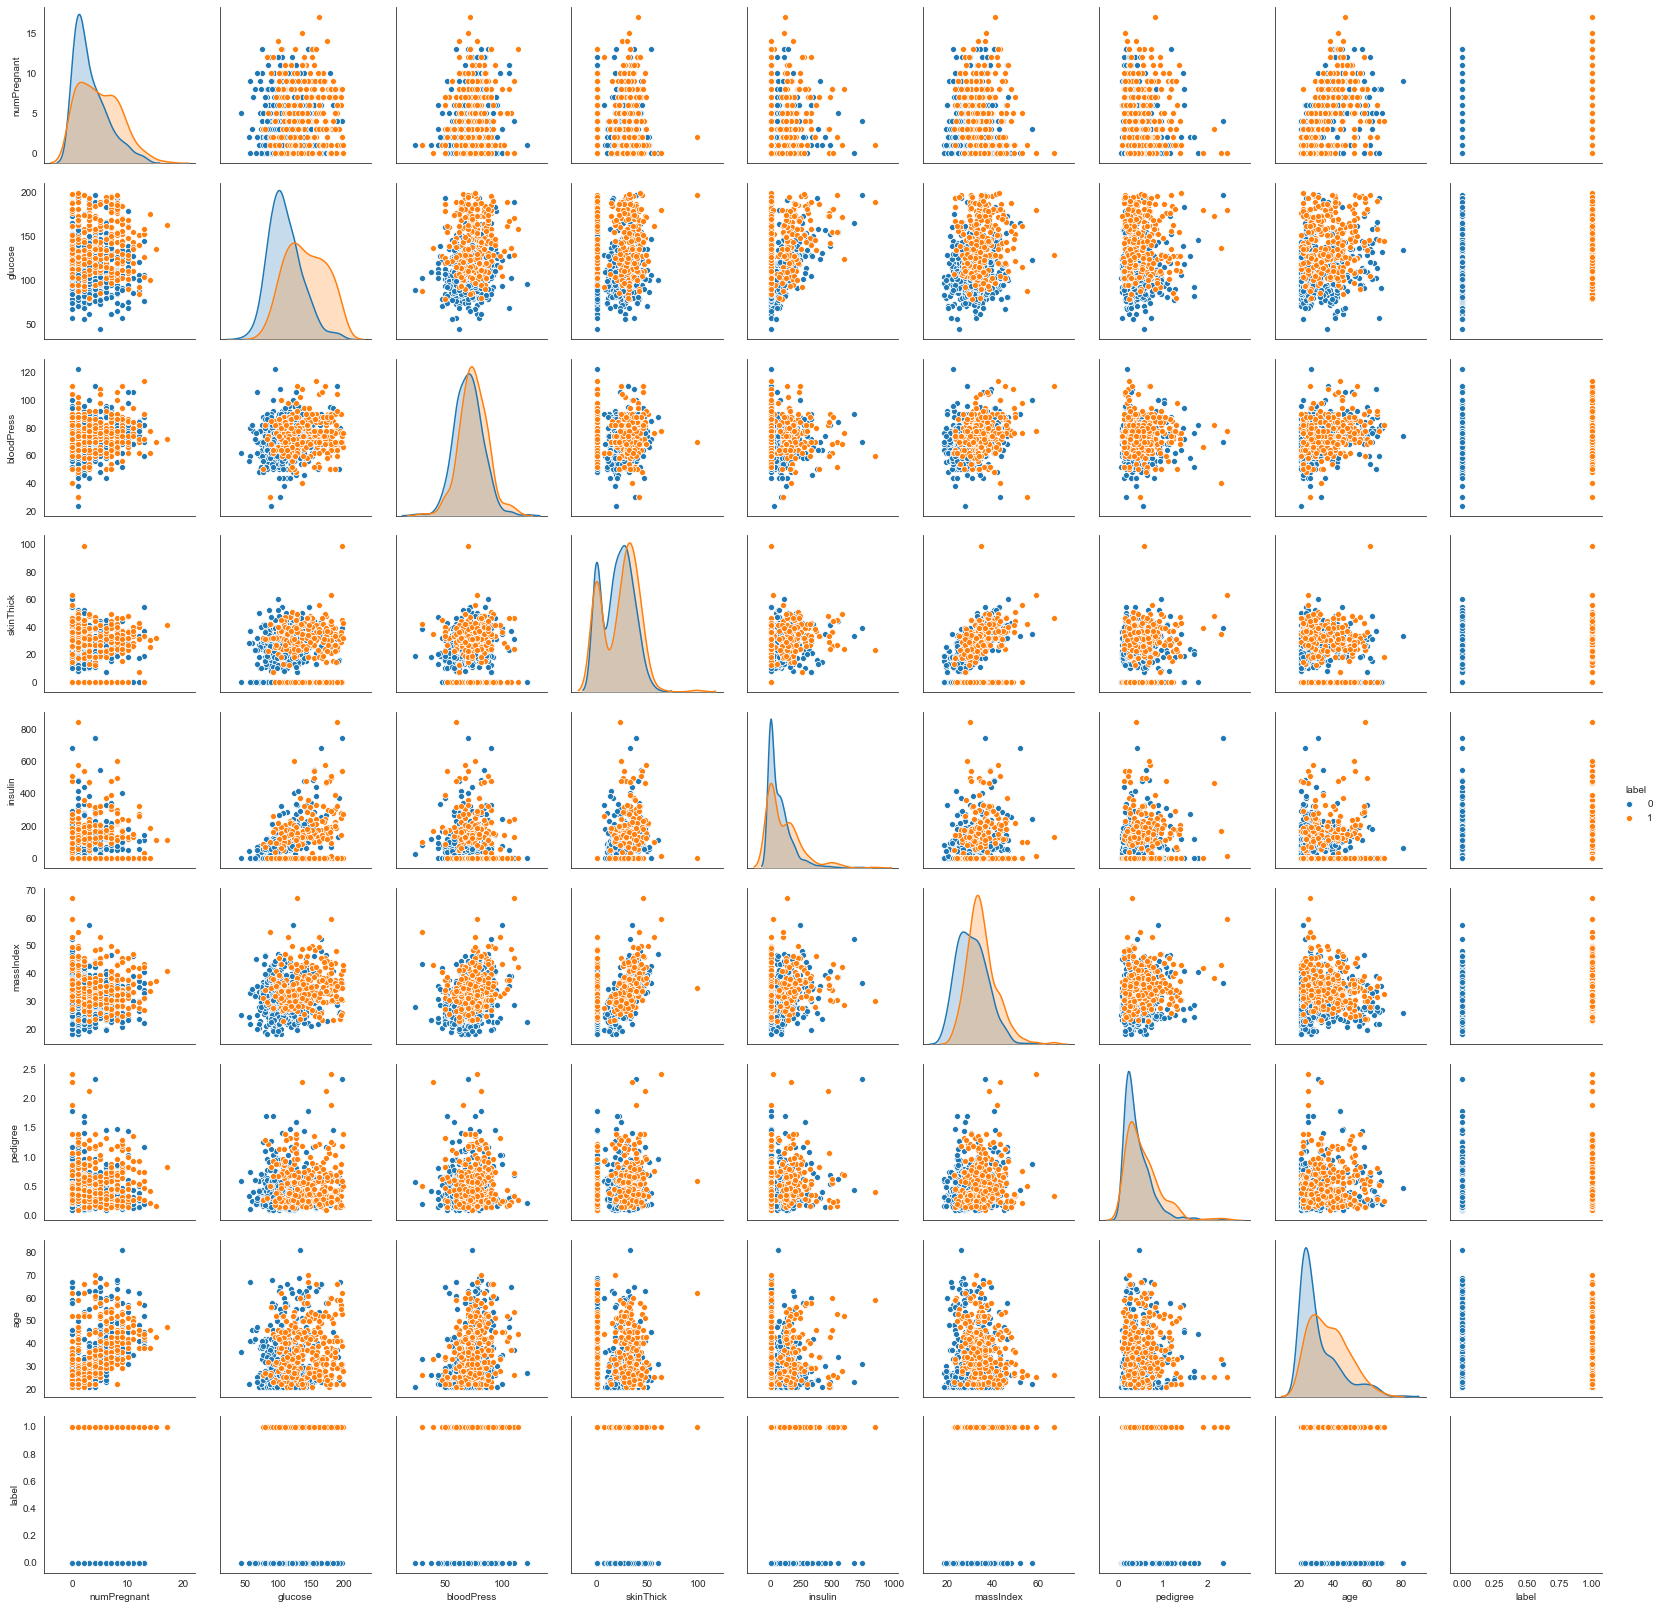

In [10]:
pair_plot = sns.pairplot( df_pima , hue= 'label', diag_kind="kde", diag_kws=dict(shade=True))
plt.show()

We always check scatterplots and correlations, but now their relationship with the 0, 1 target is now less relevant.

### Positive vs Negative Feature Histograms

A clssification problem is more or less solvable depending on the overlap of patterns across classes.

We check this for each feature.

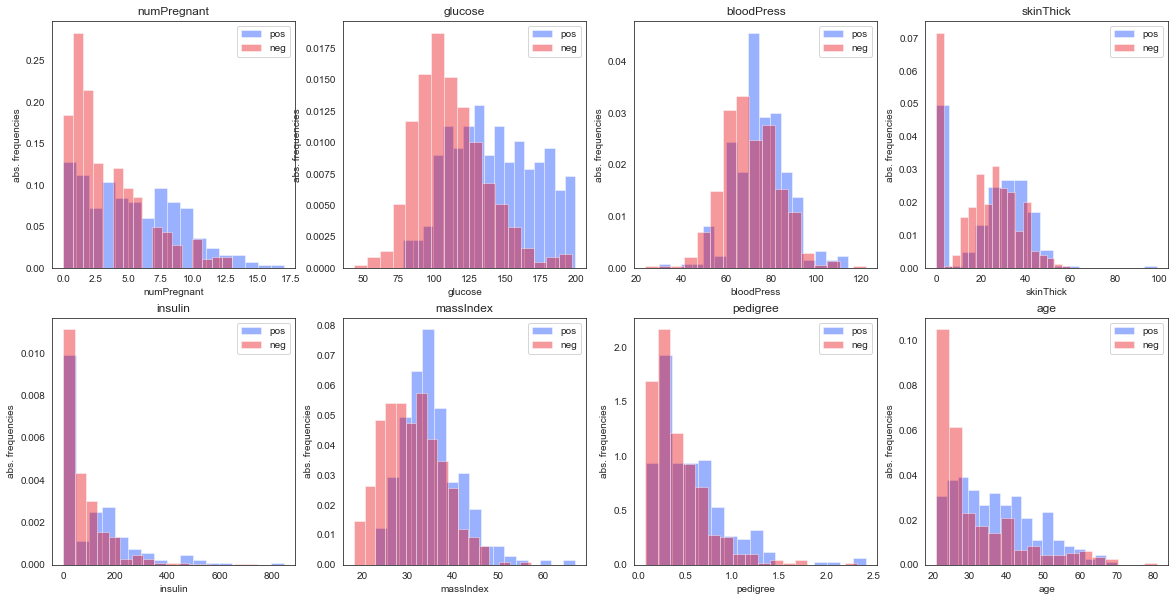

In [11]:
# But it's better to have the positive and negative histograms together

#sns.set(color_codes=True)
sns.set_color_codes("bright")
sns.set_style("white")

num_columns = 4
num_rows = 2
bins = 17

plt.figure( figsize=(20, 5*num_rows))
plt.title("Pima positive vs negative histograms")

pos = np.where( df_pima[target_pima] == 1)[0]
neg = np.where( df_pima[target_pima] == 0)[0]
    
for i, var in enumerate (['numPregnant', 'glucose', 'bloodPress', 'skinThick', 'insulin', 'massIndex', 'pedigree', 'age']):
    ax = plt.subplot(num_rows, num_columns, i+1)
    ax.set_title(var)
    #plt.hist( df_pima[ var ].iloc[pos], bins=bins, color='b', label='pos', alpha=0.5)
    #plt.hist( df_pima[ var ].iloc[neg], bins=bins, color='r', label='neg', alpha=0.5)

    sns.distplot( df_pima[ var ].iloc[pos], bins=bins, norm_hist=True, kde=False, color='b', label='pos')
    sns.distplot( df_pima[ var ].iloc[neg], bins=bins, norm_hist=True, kde=False, color='r', label='neg')
    
    plt.ylabel("abs. frequencies")
    plt.legend(loc='best')

plt.show()

## Correlations

We drop the `label` column.

In [12]:
df_pima[['numPregnant', 'glucose', 'bloodPress', 'skinThick', 'insulin', 'massIndex', 'pedigree', 'age']].corr().round(decimals=3)

,numPregnant,glucose,bloodPress,skinThick,insulin,massIndex,pedigree,age
numPregnant,1.000,0.135,0.210,-0.096,-0.080,0.012,-0.026,0.557
glucose,0.135,1.000,0.223,0.074,0.338,0.223,0.137,0.264
bloodPress,0.210,0.223,1.000,0.012,-0.047,0.287,-0.000,0.325
skinThick,-0.096,0.074,0.012,1.000,0.421,0.402,0.176,-0.129
insulin,-0.080,0.338,-0.047,0.421,1.000,0.192,0.183,-0.049
massIndex,0.012,0.223,0.287,0.402,0.192,1.000,0.155,0.021
pedigree,-0.026,0.137,-0.000,0.176,0.183,0.155,1.000,0.023
age,0.557,0.264,0.325,-0.129,-0.049,0.021,0.023,1.000


Una imagen (o un heatmap) vale más que mil palabras

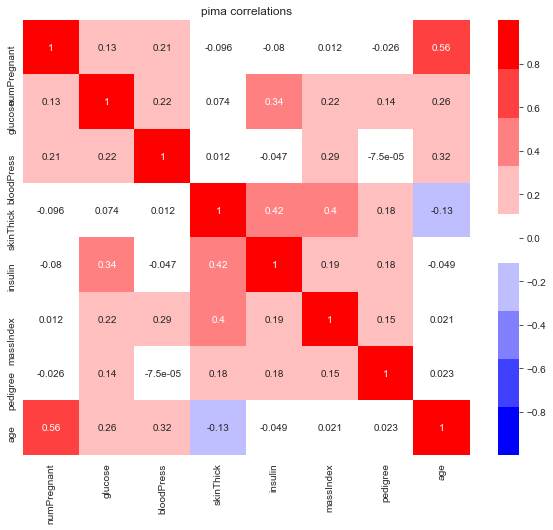

In [13]:
# definir el color map
n_colors = 9
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

# definir el heatmap
plt.figure( figsize=(10, 8))
plt.title('pima correlations')
h_map = sns.heatmap(df_pima[['numPregnant', 'glucose', 'bloodPress', 'skinThick', 'insulin', 'massIndex', 'pedigree', 'age']].corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap, 
                    annot=True, 
                    xticklabels=list(df_pima.columns[ : -1]),
                    yticklabels=list(df_pima.columns[ : -1]))
plt.xticks(rotation=90) 

# poner ticks en la barra de colores
cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

# arreglar cosillas
bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

# generar el dibujo
plt.show()

## k-NN Classification

Vamos a probar un modelo alternativo

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

x = df_pima[ vars_pima ].values
y = df_pima[ target_pima ].values

std_sc = StandardScaler()
x = std_sc.fit_transform(x)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x, y) 

y_pred = neigh.predict(x)

acc    = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
prec   = precision_score(y, y_pred) 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))

print("\nconfusion matrix:\n", confusion_matrix(y, y_pred))

acc: 0.855	recall: 0.743	precision: 0.819

confusion matrix:
 [[434  41]
 [ 64 185]]


### Grid Search of Optimal Number of neighbors

In [15]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

l_k = [1 + 2**k for k in range(1, 9)]
l_weights = ['uniform', 'distance']
param_grid = {'n_neighbors': l_k, 'weights': l_weights}
#param_grid = {'n_neighbors': l_k}

# we use stratified folds
n_folds = 10
skf = StratifiedKFold(n_folds, 
                      shuffle=True)
nn_weights = 'uniform'
nn_weights = 'distance'
neigh = KNeighborsClassifier(weights=nn_weights)

nn_k_search = GridSearchCV(neigh, 
                           param_grid=param_grid, 
                           cv=skf, 
                           scoring='accuracy', 
                           iid=True,
                           return_train_score=True, 
                           n_jobs=2, 
                           verbose=1)

print("GridSearch over a list of neighbors/labels:", l_k, l_weights)
_ = nn_k_search.fit(x, y)

GridSearch over a list of neighbors/labels: [3, 5, 9, 17, 33, 65, 129, 257] ['uniform', 'distance']
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  93 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done 157 out of 160 | elapsed:    9.6s remaining:    0.1s
[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed:    9.7s finished


### Search Results Analysis

Comprobamos los parámetros de los mejores modelos.

In [16]:
df_nn_k_search = pd.DataFrame.from_dict(nn_k_search.cv_results_)

display(df_nn_k_search[["param_n_neighbors", "param_weights", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_n_neighbors,param_weights,mean_test_score
8,33,uniform,0.767956
9,33,distance,0.763812
6,17,uniform,0.762431
7,17,distance,0.762431
11,65,distance,0.759669


Dibujamos todos los scores.

Están "duplicados" al haber considerado dos distancias.

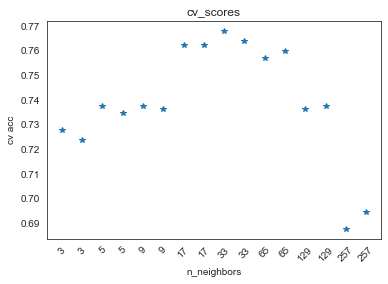

In [17]:
l_k_2 = []
for k in l_k:
    l_k_2 += [k, k]
    
plt.title("cv_scores")
plt.xlabel('n_neighbors')
plt.ylabel('cv acc')
plt.xticks(range(2*len(l_k)), l_k_2, rotation=45)
_ = plt.plot( df_nn_k_search['mean_test_score'], '*')
plt.show()

### Accuracy, Precision y Recall 

In [18]:
best_k = nn_k_search.best_params_['n_neighbors']
best_weights = nn_k_search.best_params_['weights']

print("best_k: %d\tbest_weights: %s" % (best_k, best_weights))

neigh = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights)

# accuracies
acc_cv_scores = cross_val_score(neigh, 
                                x, 
                                y, 
                                cv=skf, 
                                scoring='accuracy')

print ("acc_cv_scores:\n\t", acc_cv_scores)
print("\n\tcv_acc_mean: %.3f\n" % (acc_cv_scores.mean()))

# recall
recall_cv_scores = cross_val_score(neigh, x, y, 
                                   cv=skf, 
                                   scoring='recall')
print ("recall_cv_scores:\n\t", recall_cv_scores)
print("\n\tcv_recall_mean: %.3f\n" % (recall_cv_scores.mean()))

# precision
prec_cv_scores = cross_val_score(neigh, x, y, 
                                 cv=skf, 
                                 scoring='precision')
print ("precision_cv_scores:\n\t", prec_cv_scores)
print("\n\tcv_precisison_mean: %.3f\n" % (prec_cv_scores.mean()))

best_k: 33	best_weights: uniform
acc_cv_scores:
	 [0.822 0.822 0.836 0.753 0.753 0.722 0.722 0.819 0.75  0.746]

	cv_acc_mean: 0.775

recall_cv_scores:
	 [0.4   0.48  0.48  0.52  0.6   0.44  0.4   0.52  0.56  0.417]

	cv_recall_mean: 0.482

precision_cv_scores:
	 [0.667 0.583 0.692 0.706 0.786 0.762 0.81  0.765 0.632 0.857]

	cv_precisison_mean: 0.726



## Logistic Regression

Just getting started ...

We first run a single model over all data and then explore CV.

In all cases we use l2 penalty, the newton-cg solver and a penalty C=1.

b: -0.884038


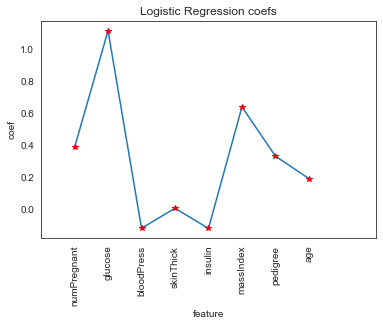

In [19]:
########## build a first log regression model

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

x = df_pima[ vars_pima ].values
y = df_pima[ target_pima ].values

# scale data
std_sc = StandardScaler()
x = std_sc.fit_transform(x)

# the default regularization value is C=1.
logr_m =  LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000)

# fit sobre la muestra completa, sin split train-test
logr_m.fit(x, y)

print("b: %f" % logr_m.intercept_)

nticks_coefs = len(df_pima.columns)-1
plt.title('Logistic Regression coefs')
plt.xlabel('feature')
plt.ylabel('coef')
plt.xlim(-1, nticks_coefs+1)
#plt.ylim(-1., 1.)
plt.xticks(range(nticks_coefs), vars_pima, rotation='vertical')
_ = plt.plot(logr_m.coef_.reshape( x.shape[1] ), '-', logr_m.coef_.reshape( x.shape[1] ), 'r*')

### CV estimates of accuracy, recall, precision and confusion matrix

In [20]:
########## cv values of accuracy, precision, recall
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

logr_m =  LogisticRegression(solver='lbfgs')

n_folds = 10
skf = StratifiedKFold(n_folds, 
                      shuffle=True)

# accuracies
y_pred = cross_val_predict(logr_m, 
                           x,
                           y,
                           cv=skf)

acc    = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
prec   = precision_score(y, y_pred) 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))

print("\nconfusion matrix:\n", confusion_matrix(y, y_pred))

acc: 0.775	recall: 0.566	precision: 0.719

confusion matrix:
 [[420  55]
 [108 141]]


## Tuning `C` in Logistic Regression

We select the log regression regularization parameter `C` by CV using sklearn randomized search

**Note**: `C` penalizes $\|w\|^2$ as `1./alpha/num_patterns`

We estimate the optimal `C` again by CV.

In [22]:
########## find best regularization parameter C = 1./alpha
# First iteration to find an initial alpha; repeat if needed
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

n_folds = 10
skf = StratifiedKFold(n_folds, 
                      shuffle=True)

logr = LogisticRegression(solver='lbfgs', 
                          max_iter=1000)
inner_estimator = Pipeline(steps=[('std_sc', StandardScaler()),
                                  ('logr', logr)])

l_C = [10.**k for k in range(-6, 10)]
param_grid = {'logr__C': l_C}


# we use GridSearchCV which uses by default stratified folds
cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=skf, 
                            scoring='accuracy', 
                            iid=True,
                            return_train_score=True, 
                            n_jobs=2, 
                            verbose=1)
_ = cv_estimator.fit(x, y)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed:    2.3s finished


### Analyzing the CV results

We plot the CV errors with respect to `C` to check on the adequacy of the best hyperparameter.

Comprobamos los parámetros de los mejores modelos.

In [23]:
df_cv_estimator = pd.DataFrame.from_dict(cv_estimator.cv_results_)

display(df_cv_estimator[["param_logr__C", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_logr__C,mean_test_score
6,1,0.777624
7,10,0.776243
8,100,0.776243
9,1000,0.776243
10,10000,0.776243


best C: 1.0000 	acc: 0.778


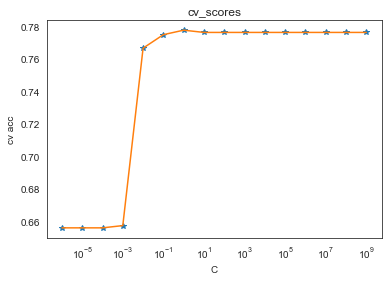

In [24]:
best_C = cv_estimator.best_params_['logr__C']
print("best C: %.4f" % (best_C), 
      "\tacc: %.3f" % cv_estimator.best_score_) 

plt.title("cv_scores")
plt.xlabel('C')
plt.ylabel('cv acc')
plt.xscale('log')
_ = plt.plot( df_cv_estimator['param_logr__C'], df_cv_estimator['mean_test_score'], '*',
              df_cv_estimator['param_logr__C'], df_cv_estimator['mean_test_score'], '-')

### Analyzing the performance of the best hyperparameter

In [25]:
### CV accuracy, recall and precision of best model
y_pred = cross_val_predict(cv_estimator.best_estimator_, x, y, cv=skf, n_jobs=2)

acc    = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
prec   = precision_score(y, y_pred) 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))

print("\nconfusion matrix:\n", confusion_matrix(y, y_pred))

acc: 0.773	recall: 0.562	precision: 0.718

confusion matrix:
 [[420  55]
 [109 140]]


## Predicting probabilities

In classification we should give class probability estimates rather than labels.

In [26]:
######### plot prob histograms
from sklearn.model_selection import cross_val_predict

log_r_m = cv_estimator.best_estimator_

p_pred_log_r = cross_val_predict(log_r_m, x, y, cv=skf,
                                 method='predict_proba')

We build the histogram of the posterior probabilities predicted for the positive class and decide on adequate thresholds.

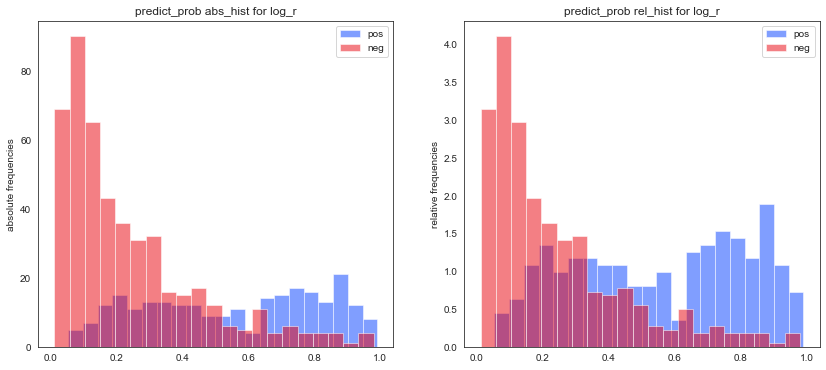

In [27]:
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]

bins = 21

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("predict_prob abs_hist for log_r")
plt.ylabel("absolute frequencies")
plt.hist( p_pred_log_r[pos, 1], bins=bins, density=False, color='b', label='pos', alpha=0.5)
plt.hist( p_pred_log_r[neg, 1], bins=bins, density=False, color='r', label='neg', alpha=0.5)
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title("predict_prob rel_hist for log_r")
plt.ylabel("relative frequencies")
plt.hist( p_pred_log_r[pos, 1], bins=bins, density=True, color='b', label='pos', alpha=0.5)
plt.hist( p_pred_log_r[neg, 1], bins=bins, density=True, color='r', label='neg', alpha=0.5)
#sns.distplot( p_pred_log_r[pos, 1], bins=bins, norm_hist=True, kde=False, color='b', label='pos')
#sns.distplot( p_pred_log_r[neg, 1], bins=bins, norm_hist=True, kde=False, color='r', label='neg')
plt.legend(loc='best')

plt.show()

### Applying classification models

Diabetes is a serious illness so we should try to improve recall as much as possible taking also into account our resources.

We explore the effect on the classification performance of lowering the decision threshold for positives below 0.5.

In [28]:
######### threshold analysis
num_patterns = x.shape[0]
l_thresholds = [0.5, 0.4, 0.3, 0.2]

for thresh in l_thresholds:
    y_pred_thresh = np.zeros( num_patterns ) 
    pos_thresh = np.where(p_pred_log_r[ :, 1] > thresh)[0]
    y_pred_thresh[pos_thresh] = 1

    print("threshold:", thresh)
    print("confusion matrix\n", confusion_matrix(y, y_pred_thresh) )
    print("\n\taccuracy\t%.3f"    %   accuracy_score(y, y_pred_thresh) )
    print("\trecall\t\t%.3f"      %   recall_score(y, y_pred_thresh) )
    print("\tprecision\t%.3f"     %   precision_score(y, y_pred_thresh) )
    print("\tnum_alertas\t%d\n\n" %   confusion_matrix(y, y_pred_thresh)[ : , 1 ].sum() )    

threshold: 0.5
confusion matrix
 [[422  53]
 [109 140]]

	accuracy	0.776
	recall		0.562
	precision	0.725
	num_alertas	193


threshold: 0.4
confusion matrix
 [[392  83]
 [ 84 165]]

	accuracy	0.769
	recall		0.663
	precision	0.665
	num_alertas	248


threshold: 0.3
confusion matrix
 [[343 132]
 [ 57 192]]

	accuracy	0.739
	recall		0.771
	precision	0.593
	num_alertas	324


threshold: 0.2
confusion matrix
 [[269 206]
 [ 26 223]]

	accuracy	0.680
	recall		0.896
	precision	0.520
	num_alertas	429




## MLP Classifier

In [29]:
from sklearn.neural_network import MLPClassifier

x = df_pima[ vars_pima ].values
y = df_pima[ target_pima ].values

# scale data
std_sc = StandardScaler()
x = std_sc.fit_transform(x)

### CV Hyperparametrization

In [31]:
n_folds = 10
skf = StratifiedKFold(n_folds, shuffle=True)

#hidden_layer_sizes = (20, 20)
l_hidden_layer_sizes = [(20,), (20, 20), (20, 20, 20)]
l_alpha = [10.**k for k in range(-6, 4)]

#param_grid = {'mlp__alpha': l_alpha}
param_grid = {'mlp__alpha': l_alpha, 'mlp__hidden_layer_sizes': l_hidden_layer_sizes}

mlp_c = MLPClassifier(solver='adam', 
                      activation='relu',
                      tol=1.e-4, 
                      max_iter=1000,
                      warm_start=False,
                      shuffle=True)

inner_estimator = Pipeline(steps=[('std_sc', StandardScaler()),
                                  ('mlp', mlp_c)])

cv_estimator_0 = GridSearchCV(inner_estimator, 
                              param_grid=param_grid, 
                              cv=skf, 
                              scoring='accuracy', 
                              iid=True,
                              return_train_score=True, 
                              n_jobs=2, 
                              verbose=1)

t_0 = time.time() 
_ = cv_estimator_0.fit(x, y)
t_1 = time.time() 
print("\nmlp_grid_search_time: %.2f" % ((t_1 - t_0)/60.))
        
# saving alpha_search in a pickle    
f = gzip.open('mlp_cl_alpha_search_results.pkz', mode='wb', compresslevel=9)
pickle.dump(cv_estimator_0, f, protocol=3)
f.close()

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 14.0min
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed: 16.8min finished



mlp_grid_search_time: 16.87


### Analyzing the CV results

We check first the best models' params.

In [32]:
df_cv_estimator = pd.DataFrame.from_dict(cv_estimator_0.cv_results_)

display(df_cv_estimator[["param_mlp__alpha", "param_mlp__hidden_layer_sizes", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_mlp__alpha,param_mlp__hidden_layer_sizes,mean_test_score
21,10,"(20,)",0.773481
18,1,"(20,)",0.766575
12,0.01,"(20,)",0.765193
22,10,"(20, 20)",0.765193
19,1,"(20, 20)",0.765193


We plot the CV errors to check on the adequacy of the best hyperparameter.

best alpha: 10.000000	
alpha_min: 0.000001	alpha_max: 1000.000000
best_hidden_layer_sizes (20,) 
acc: 0.773


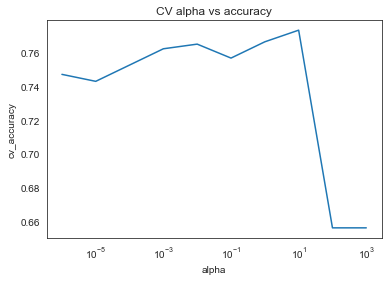

In [33]:
f = gzip.open('mlp_cl_alpha_search_results.pkz', mode='rb')
cv_estimator_0 = pickle.load(f)
f.close()

best_alpha = cv_estimator_0.best_params_['mlp__alpha'] 
print("best alpha: %.6f\t" % best_alpha)
print("alpha_min: %f\talpha_max: %f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))

best_hidden_layer_sizes = cv_estimator_0.best_params_['mlp__hidden_layer_sizes'] 
print("best_hidden_layer_sizes", best_hidden_layer_sizes, "\nacc: %.3f" % cv_estimator_0.best_score_) 

idx_best_hidden_layer_sizes = [tup == best_hidden_layer_sizes for tup in df_cv_estimator['param_mlp__hidden_layer_sizes'].values]
idx_best_hidden_layer_sizes = np.array(idx_best_hidden_layer_sizes)

plt.title("CV alpha vs accuracy")
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("cv_accuracy")
_ = plt.plot( df_cv_estimator[idx_best_hidden_layer_sizes]['param_mlp__alpha'], 
              df_cv_estimator[idx_best_hidden_layer_sizes]['mean_test_score'])

The accuracy graph is not too conclusive so we repeat the CV search in a narrower range.

In [34]:
#Second try
l_hidden_layer_sizes = [(20,), (20, 20), (20, 20, 20)]
l_alpha = [best_alpha * 2.**k for k in range(-5, 4)]

param_grid = {'mlp__alpha': l_alpha, 'mlp__hidden_layer_sizes': l_hidden_layer_sizes}

cv_estimator_1 = GridSearchCV(inner_estimator, 
                              param_grid=param_grid, 
                              cv=skf, 
                              scoring='accuracy', 
                              iid=True,
                              return_train_score=True,
                              n_jobs=2, 
                              verbose=1)

_ = cv_estimator_1.fit(x, y)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done 270 out of 270 | elapsed:  7.3min finished


In [35]:
df_cv_estimator = pd.DataFrame.from_dict(cv_estimator_1.cv_results_)

display(df_cv_estimator[["param_mlp__alpha", "param_mlp__hidden_layer_sizes", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_mlp__alpha,param_mlp__hidden_layer_sizes,mean_test_score
9,2.5,"(20,)",0.774862
16,10,"(20, 20)",0.773481
15,10,"(20,)",0.773481
14,5,"(20, 20, 20)",0.772099
10,2.5,"(20, 20)",0.772099


We check the best parameter and plot the cv accuracies.

best alpha: 2.500000	
alpha_min: 0.312500	alpha_max: 80.000000
best_hidden_layer_sizes (20,) 
acc: 0.775


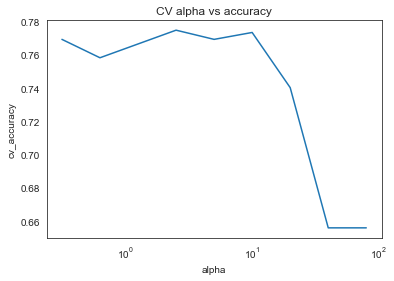

In [36]:
best_alpha = cv_estimator_1.best_params_['mlp__alpha'] 
print("best alpha: %.6f\t" % best_alpha)
print("alpha_min: %f\talpha_max: %f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))

best_hidden_layer_sizes = cv_estimator_1.best_params_['mlp__hidden_layer_sizes'] 
print("best_hidden_layer_sizes", best_hidden_layer_sizes, "\nacc: %.3f" % cv_estimator_1.best_score_) 

idx_best_hidden_layer_sizes = [tup == best_hidden_layer_sizes for tup in df_cv_estimator['param_mlp__hidden_layer_sizes'].values]
idx_best_hidden_layer_sizes = np.array(idx_best_hidden_layer_sizes)

plt.title("CV alpha vs accuracy")
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("cv_accuracy")
_ = plt.plot( df_cv_estimator[idx_best_hidden_layer_sizes]['param_mlp__alpha'], 
              df_cv_estimator[idx_best_hidden_layer_sizes]['mean_test_score'])

And check classifier performance

In [37]:
### CV accuracy, recall and precision of best model
y_pred = cross_val_predict(cv_estimator_1.best_estimator_, x, y, cv=skf, n_jobs=2)

acc    = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
prec   = precision_score(y, y_pred) 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))

print("\nconfusion matrix:\n", confusion_matrix(y, y_pred))

acc: 0.764	recall: 0.558	precision: 0.695

confusion matrix:
 [[414  61]
 [110 139]]


## Predicting probabilities

We compute class probabilities and compare them with those obtained with logistic regression.

In [38]:
######### plot prob histograms
from sklearn.model_selection import cross_val_predict

p_pred_mlp = cross_val_predict(cv_estimator_1.best_estimator_, x, y, 
                               cv=skf,
                               method='predict_proba')

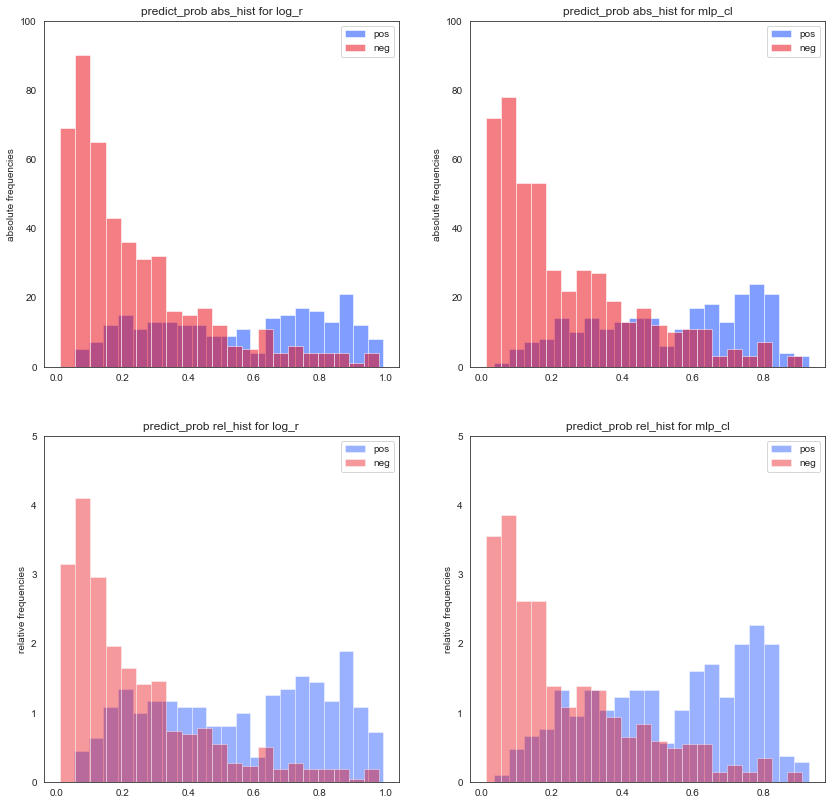

In [39]:
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]

bins = 21

plt.figure(figsize=(14, 14))

# first log_r
plt.subplot(2, 2, 1)
plt.title("predict_prob abs_hist for log_r")
plt.ylabel("absolute frequencies")
plt.ylim(0., 100.)
plt.hist( p_pred_log_r[pos, 1], bins=bins, density=False, color='b', label='pos', alpha=0.5)
plt.hist( p_pred_log_r[neg, 1], bins=bins, density=False, color='r', label='neg', alpha=0.5)
plt.legend(loc='best')

plt.subplot(2, 2, 3)
plt.title("predict_prob rel_hist for log_r")
plt.ylabel("relative frequencies")
plt.ylim(0., 5.)
sns.distplot( p_pred_log_r[pos, 1], bins=bins, norm_hist=True, kde=False, color='b', label='pos')
sns.distplot( p_pred_log_r[neg, 1], bins=bins, norm_hist=True, kde=False, color='r', label='neg')
plt.legend(loc='best')

# now log_r
plt.subplot(2, 2, 2)
plt.title("predict_prob abs_hist for mlp_cl")
plt.ylabel("absolute frequencies")
plt.ylim(0., 100.)
plt.hist( p_pred_mlp[pos, 1], bins=bins, density=False, color='b', label='pos', alpha=0.5)
plt.hist( p_pred_mlp[neg, 1], bins=bins, density=False, color='r', label='neg', alpha=0.5)
plt.legend(loc='best')

plt.subplot(2, 2, 4)
plt.title("predict_prob rel_hist for mlp_cl")
plt.ylabel("relative frequencies")
plt.ylim(0., 5.)
sns.distplot( p_pred_mlp[pos, 1], bins=bins, norm_hist=True, kde=False, color='b', label='pos')
sns.distplot( p_pred_mlp[neg, 1], bins=bins, norm_hist=True, kde=False, color='r', label='neg')
plt.legend(loc='best')

plt.show()

### Applying classification models

We examine model performance for different thresholds.

In [40]:
######### threshold analysis
num_patterns = x.shape[0]
l_thresholds = [0.5, 0.4, 0.3, 0.2]

for thresh in l_thresholds:
    y_pred_thresh = np.zeros( num_patterns ) 
    pos_thresh = np.where(p_pred_mlp[ :, 1] > thresh)[0]
    y_pred_thresh[pos_thresh] = 1

    print("threshold:", thresh)
    print("confusion matrix\n", confusion_matrix(y, y_pred_thresh) )
    print("\n\taccuracy\t%.3f"    %   accuracy_score(y, y_pred_thresh) )
    print("\trecall\t\t%.3f"      %   recall_score(y, y_pred_thresh) )
    print("\tprecision\t%.3f"     %   precision_score(y, y_pred_thresh) )
    print("\tnum_alertas\t%d\n\n" %   confusion_matrix(y, y_pred_thresh)[ : , 1 ].sum() )

threshold: 0.5
confusion matrix
 [[414  61]
 [111 138]]

	accuracy	0.762
	recall		0.554
	precision	0.693
	num_alertas	199


threshold: 0.4
confusion matrix
 [[381  94]
 [ 76 173]]

	accuracy	0.765
	recall		0.695
	precision	0.648
	num_alertas	267


threshold: 0.3
confusion matrix
 [[324 151]
 [ 47 202]]

	accuracy	0.727
	recall		0.811
	precision	0.572
	num_alertas	353


threshold: 0.2
confusion matrix
 [[263 212]
 [ 20 229]]

	accuracy	0.680
	recall		0.920
	precision	0.519
	num_alertas	441




These are similar but sometimes worse than those of Logistic Regression